In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
# Load the dataset
data = pd.read_csv(r'C:\Users\sivar\Downloads\District_Statewise_Well.csv')

In [3]:
# Dropping irrelevant columns if needed (e.g., 'S.no.')
data = data.drop(columns=['S.no.'], errors='ignore')

In [4]:
# Handle missing values using forward fill
data.ffill(inplace=True)

In [5]:
# Target column for prediction
target_column = 'Net Ground Water Availability for future use'


In [6]:
# Function to generate lag features for the past 3 months
def create_lag_features(df, target_column, lags):
    for lag in range(1, lags + 1):
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df

In [7]:
# Encoding categorical columns like 'Name of State' and 'Name of District'
label_encoder = LabelEncoder()
data['Name of State'] = label_encoder.fit_transform(data['Name of State'])
data['Name of District'] = label_encoder.fit_transform(data['Name of District'])


In [8]:
# Create lag features for the past 3 months
data = create_lag_features(data, target_column, 3)

In [9]:
# Drop rows with NaN values due to lag feature creation
data.dropna(inplace=True)


In [10]:
# Split features and target
X = data.drop(columns=[target_column])
y = data[target_column]

In [11]:
# Optional: Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:
# Model training with XGBoost and hyperparameter tuning
xgb_model = xgb.XGBRegressor(
    n_estimators=200,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=5,  # Maximum depth of the tree
    subsample=0.8,  # Fraction of samples used for each tree
    colsample_bytree=0.8,  # Fraction of features used for each tree
    random_state=42
)

In [14]:
# Fit the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
# Prediction
y_pred = xgb_model.predict(X_test)

In [16]:
# Evaluation using RMSE, MAE, and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [17]:
# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")  # Rounded to 2 decimal places
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.5f}")


RMSE: 8631.21
MAE: 4030.42
R^2: 0.92116


In [18]:
# Display the actual vs predicted values for the first 10 samples
actual_vs_predicted = pd.DataFrame({'Actual': y_test.values[:10], 'Predicted': y_pred[:10]})
print(actual_vs_predicted)

     Actual     Predicted
0   5474.79   3700.003418
1  43833.19  38415.109375
2  23491.50  21471.136719
3  34950.75  42040.246094
4  27661.66  28307.681641
5    444.02   -268.090881
6  27738.59  22962.531250
7   2463.00   6020.179199
8  31411.54  33132.851562
9  27053.42  26410.560547


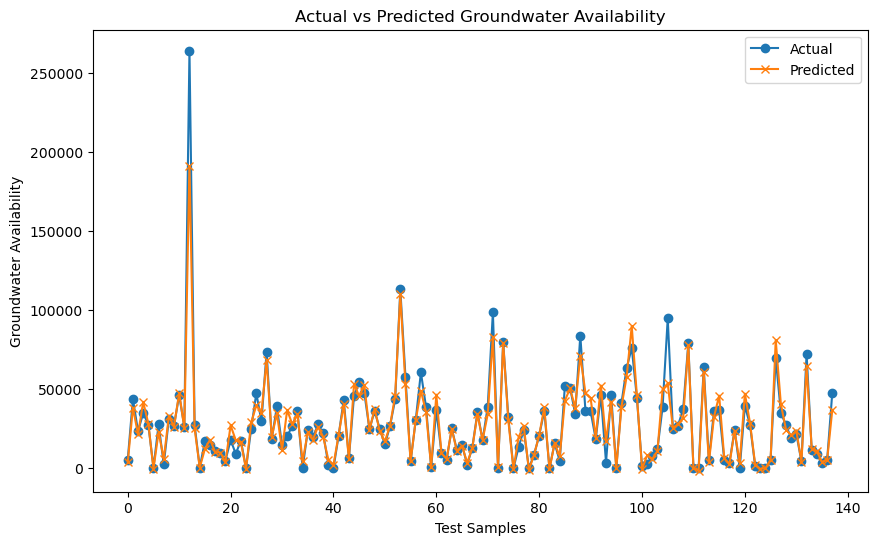

In [19]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.legend()
plt.title("Actual vs Predicted Groundwater Availability")
plt.xlabel("Test Samples")
plt.ylabel("Groundwater Availability")
plt.show()
